In [35]:
using FFTW
using LinearAlgebra
using BenchmarkTools
using Random
using PyPlot

## Objective and stuff

$$ \min \| M \cdot ( X - \hat X) \|^2 $$


$$ \hat X = \sum_\ell W_\ell H S_{\ell-1} $$

$$ \hat X = \sum_k W_k * h_k^T $$

$$ (W * h^T)_{nt} = \sum_{\ell=1}^L W_{n \ell} h_{t +1 - \ell} $$

In [10]:
function s_dot(Wl::Matrix, H::Matrix, lag)
    K, T = size(H)

    if (lag < 0)
        return Wl * H[:, 1-lag:T]

    else  # lag >= 0
        return Wl * H[:, 1:T-lag]
    end
end

function tensor_conv(W, H)
    L, N, K = size(W)
    T = size(H)[2]

    pred = zeros(N, T)
    for lag = 0:(L-1)
        pred[:, lag+1:T] += s_dot(W[lag+1, :, :], H, lag)
    end
    return pred
end

N, T, L, K = 1, 50, 7, 1
W = rand(L, N, K)
H = rand(K, T)
H = [zeros(K, L) H zeros(K, L)]

X = tensor_conv(W, H);

In [11]:
# Zero pad H
#Hpad = [H zeros(K, L)]

# Zero pad W
Wpad = vcat(W, zeros(T+L, N, K))  # Potentially zero back

@show size(Wpad)
@show size(H);

size(Wpad) = (64, 1, 1)
size(H) = (1, 64)


In [12]:
# Take fft of H
Hpadhat1 = Array{Complex, 2}(undef, size(H)...)
for k = 1:K
    Hpadhat1[k, :] = fft(H[k, :])
end
Hpadhat2 = fft(H, 2)

@show size(Hpadhat1)
@show size(Hpadhat2)
@show norm(Hpadhat1 - Hpadhat2)

ftH = Hpadhat2;

size(Hpadhat1) = (1, 64)
size(Hpadhat2) = (1, 64)
norm(Hpadhat1 - Hpadhat2) = 0.0


In [13]:
# Take fft of W
ftW1 = Array{Complex, 3}(undef, size(Wpad)...)
for k = 1:K
    for n = 1:N
        ftW1[:, n, k] = fft(Wpad[:, n, k])
    end
end
ftW2 = fft(Wpad, 1)

@show size(ftW1)
@show size(ftW2)
@show norm(ftW1 - ftW2)

ftW = ftW2;

size(ftW1) = (64, 1, 1)
size(ftW2) = (64, 1, 1)
norm(ftW1 - ftW2) = 0.0


In [14]:
# Compute tensor conv
ftX = Array{Complex{Float64}, 2}(undef, N, T+2L)
ftX .= 0.0

for n = 1:N
    for k = 1:K
        ftX[n, :] .+= ftW[:, n, k] .* ftH[k, :]
    end
end

ifftX = real.(ifft(ftX, 2))

@show norm(X - ifftX);
#@show norm(fft([X zeros(N, L)], 2) - ftX)


#@show X[1, 1:20]
#println()
#@show ifftX[1, 1:20]
;

norm(X - ifftX) = 2.5954060517554467e-15


In [15]:
function tensor_convft(W, H)
    
    ftW = fft(vcat(W, zeros(T+L, N, K)), 1)
    ftH = fft(H, 2)
    
    ftX = Array{Complex{Float64}, 2}(undef, N, T+2L)
    ftX .= 0.0

    for n = 1:N
        for k = 1:K
            @. ftX[n, :] += ftH[k, :] * ftW[:, n, k]
        end
    end
    
    return real.(ifft(ftX, 2))
end

@show norm(tensor_conv(W, H) - tensor_convft(W, H))

#@btime tensor_conv(W, H) samples=1
#@btime tensor_convft(W, H) samples=1
;

norm(tensor_conv(W, H) - tensor_convft(W, H)) = 2.5954060517554467e-15


We'll start with $K=1, N=1$ and minimize $ \| x - T(h) w \|^2 + \| I w \|^2$, which has solution

$$ w = (T(h)'T(h) + I)^{-1} T(h)' x.$$

In the Fourier domain, this looks like

$$ \hat w = \frac{ \hat h^* \cdot x }{ \hat h^* \cdot \hat h + 1 }$$

In [96]:
function shift_cols(X::Matrix, lag)
    T = size(X)[2]
    
    if (lag <= 0)
        return X[:, 1-lag:T]

    else  # lag > 0
        return X[:, 1:T-lag]
    end
end

function shift_and_stack(H::Matrix, L)
    K, T = size(H)

    H_stacked = zeros(L*K, T)
    for lag = 0:(L-1)
        H_stacked[1+K*lag:K*(lag+1), 1+lag:T] = shift_cols(H, lag)
    end

    return H_stacked
end

function lsq_solve(H, X, L)
    bigH = shift_and_stack(H, L)
    
    A = [bigH'; I]
    B = [X'; zeros(L)]
    
    return copy((A \ B)')
end

Random.seed!(3)

N, T, L, K = 1, 50, 7, 1
W = rand(L, N, K)
H = rand(K, T)
H = [zeros(K, L) H zeros(K, L)]
X = rand(N, T+2L)
bigH = shift_and_stack(H, L)

@show W_primal = lsq_solve(H, X, L)
@show (bigH * bigH' + I) \ (bigH * X')

W_primal = lsq_solve(H, X, L) = [0.36245235023722794 0.04506170503230661 0.18499883704680387 -0.04089896259325492 0.22756114944370734 0.1298186666715131 0.08168795026531633]
(bigH * bigH' + I) \ (bigH * X') = [0.362452350237228; 0.04506170503230653; 0.1849988370468041; -0.040898962593255005; 0.22756114944370745; 0.12981866667151248; 0.08168795026531675]


7×1 Array{Float64,2}:
  0.362452350237228   
  0.04506170503230653 
  0.1849988370468041  
 -0.040898962593255005
  0.22756114944370745 
  0.12981866667151248 
  0.08168795026531675 

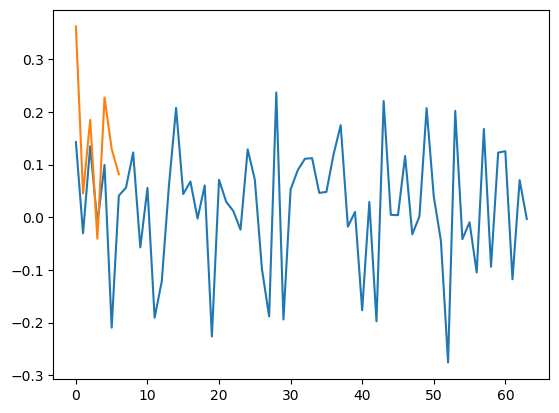

size(Xhat) = (1, 64)
size(Hhat) = (1, 64)
mindist = 0.3442497534147755


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f42dc3b1910>

In [114]:
# Solve LS for W in fourier domain
Xhat = fft(X, 2)
XhatT = conj.(Xhat)

Hhat = fft(H, 2)
HhatT = conj.(Hhat)

@show size(Xhat)
@show size(Hhat)

#num = Hhat .* conj.(Xhat)
#denom = Hhat .* conj.(Hhat)

Whata = (HhatT .* Xhat) ./ (HhatT .* Hhat .+ 1)
Whatb = (Hhat .* XhatT) ./ (Hhat .* HhatT .+ 1)

Wext = real.(ifft(conj.(Whata), 2))

mindist = Inf
for t = 1:T-L+1
    dist = norm(W_primal - Wext[:, t:t+L-1])
    if dist < mindist
        mindist = dist
    end
end

@show mindist

plot(Wext')
plot(W_primal')

In [24]:
conj(1 + 2im)

1 - 2im